# Loading Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, validation_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from hyperopt import hp, Trials, STATUS_OK, fmin, tpe

# Dataset

## Loading

In [3]:
df = pd.read_csv(r'C:\Programacion\Datasets\archive (1)\adult_train.csv')
df

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
df.drop(['fnlwgt','Education_Num'],axis=1,inplace=True)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   Education       32561 non-null  object
 3   Martial_Status  32561 non-null  object
 4   Occupation      30718 non-null  object
 5   Relationship    32561 non-null  object
 6   Race            32561 non-null  object
 7   Sex             32561 non-null  object
 8   Capital_Gain    32561 non-null  int64 
 9   Capital_Loss    32561 non-null  int64 
 10  Hours_per_week  32561 non-null  int64 
 11  Country         31978 non-null  object
 12  Target          32561 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.2+ MB


## Cleaning

In [7]:
#Invalid Values
for column in df.select_dtypes(include='object').columns:
    print(df[column].value_counts(),end='\n\n')

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: Education, dtype: int64

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Martial_Status, dtype: int64

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical

In [13]:
#MissingValues
df.isna().sum()

Age                  0
Workclass         1836
Education            0
Education_Num        0
Martial_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64

In [5]:
df.fillna({'Workclass': df.Workclass.mode()[0],
          'Occupation': df.Occupation.mode()[0],
          'Country': df.Country.mode()[0]},inplace=True)

## EDA

In [60]:
df

,Age,Workclass,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target,EducationClassification
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Graduated
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Graduated
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,Graduated
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,No graduated
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Graduated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,Graduated
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,Graduated
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,Graduated
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,Graduated


Text(0, 0.5, 'Numero de personas')

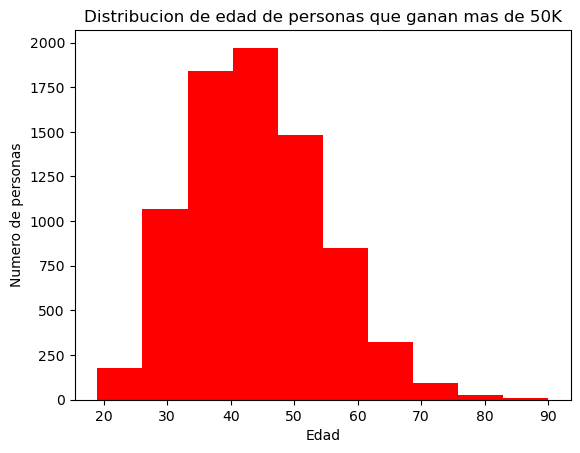

In [42]:
plt.hist(x=df.loc[df.Target==' >50K']['Age'],color='r')
plt.title('Distribucion de edad de personas que ganan mas de 50K')
plt.xlabel('Edad')
plt.ylabel('Numero de personas')

<Axes: xlabel='Age', ylabel='Density'>

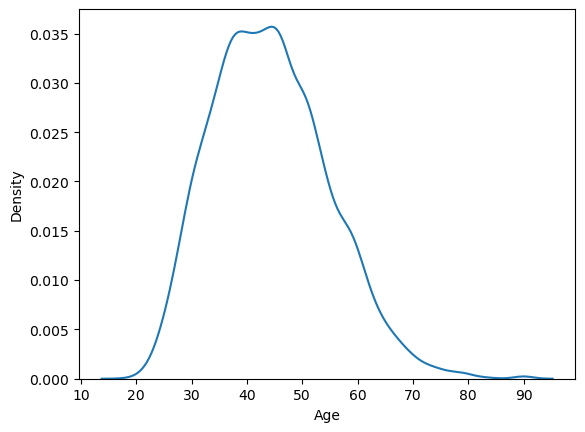

In [112]:
sns.kdeplot(x=df.loc[df.Target==' >50K']['Age'])

<Axes: title={'center': 'Area de Trabajo segun Ganancias'}, xlabel='Target'>

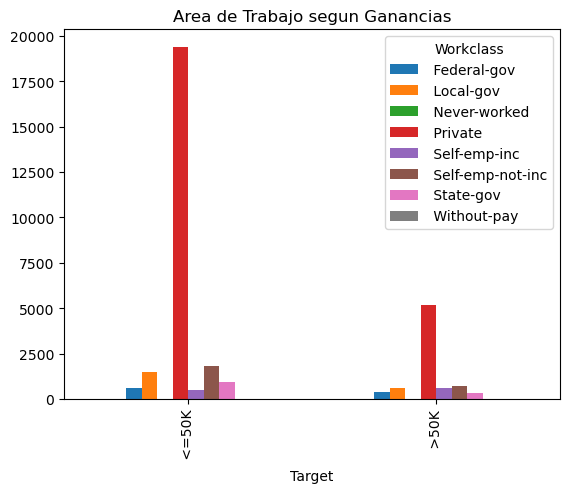

In [48]:
df.groupby('Target')['Workclass'].value_counts().unstack().plot(kind='bar',
                                                                title='Area de Trabajo segun Ganancias')

<Axes: title={'center': 'Educacion segun Ganancias'}, xlabel='Target', ylabel='Numero de personas'>

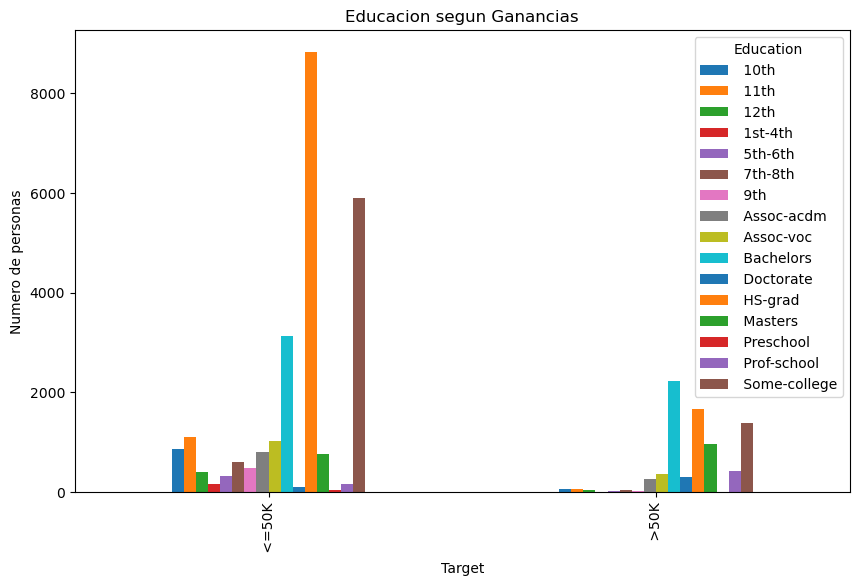

In [52]:
df.groupby('Target')['Education'].value_counts().unstack().plot(kind='bar',
                                                                title='Educacion segun Ganancias',
                                                               figsize=(10,6),
                                                               ylabel='Numero de personas')

In [6]:
no_graduated = [' 5th-6th',' 1st-4th',' 9th',' 12th',' 10th',' 7th-8th',' 11th',' Preschool',' Some-college']
df['EducationClassification'] = ['No graduated'if x in no_graduated else 'Graduated' for x in df.Education]

<Axes: title={'center': 'Educacion segun Ganancias'}, xlabel='Target', ylabel='Numero de personas'>

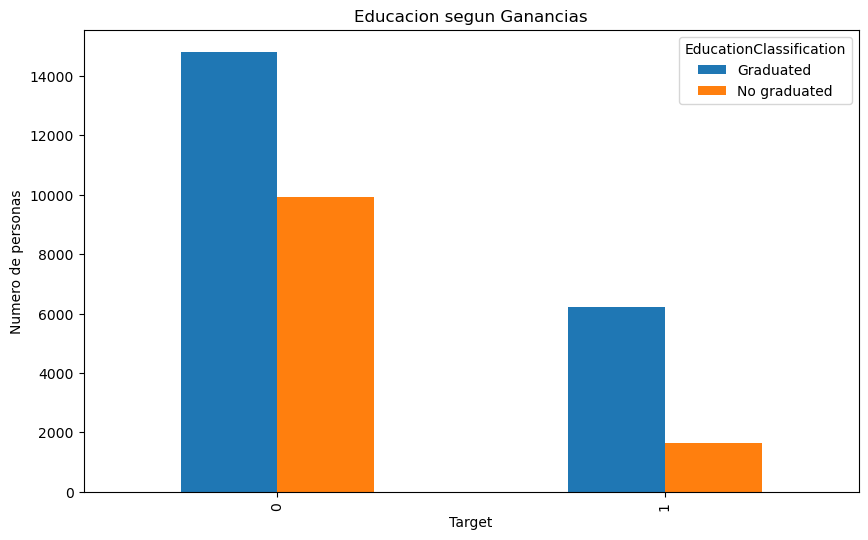

In [129]:
df.groupby('Target')['EducationClassification'].value_counts().unstack().plot(kind='bar',
                                                                title='Educacion segun Ganancias',
                                                               figsize=(10,6),
                                                               ylabel='Numero de personas')

<Axes: xlabel='Relationship', ylabel='count'>

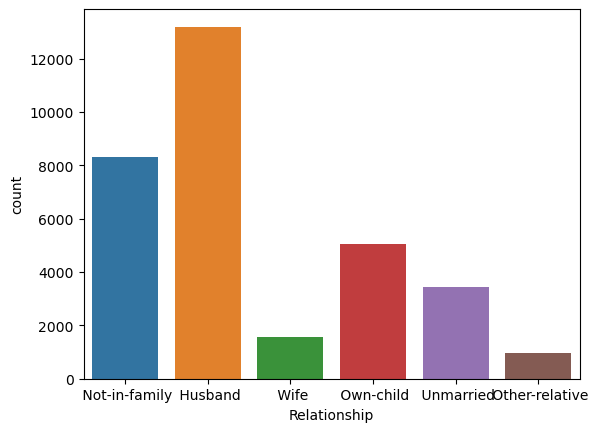

In [63]:
sns.countplot(x=df.Relationship)

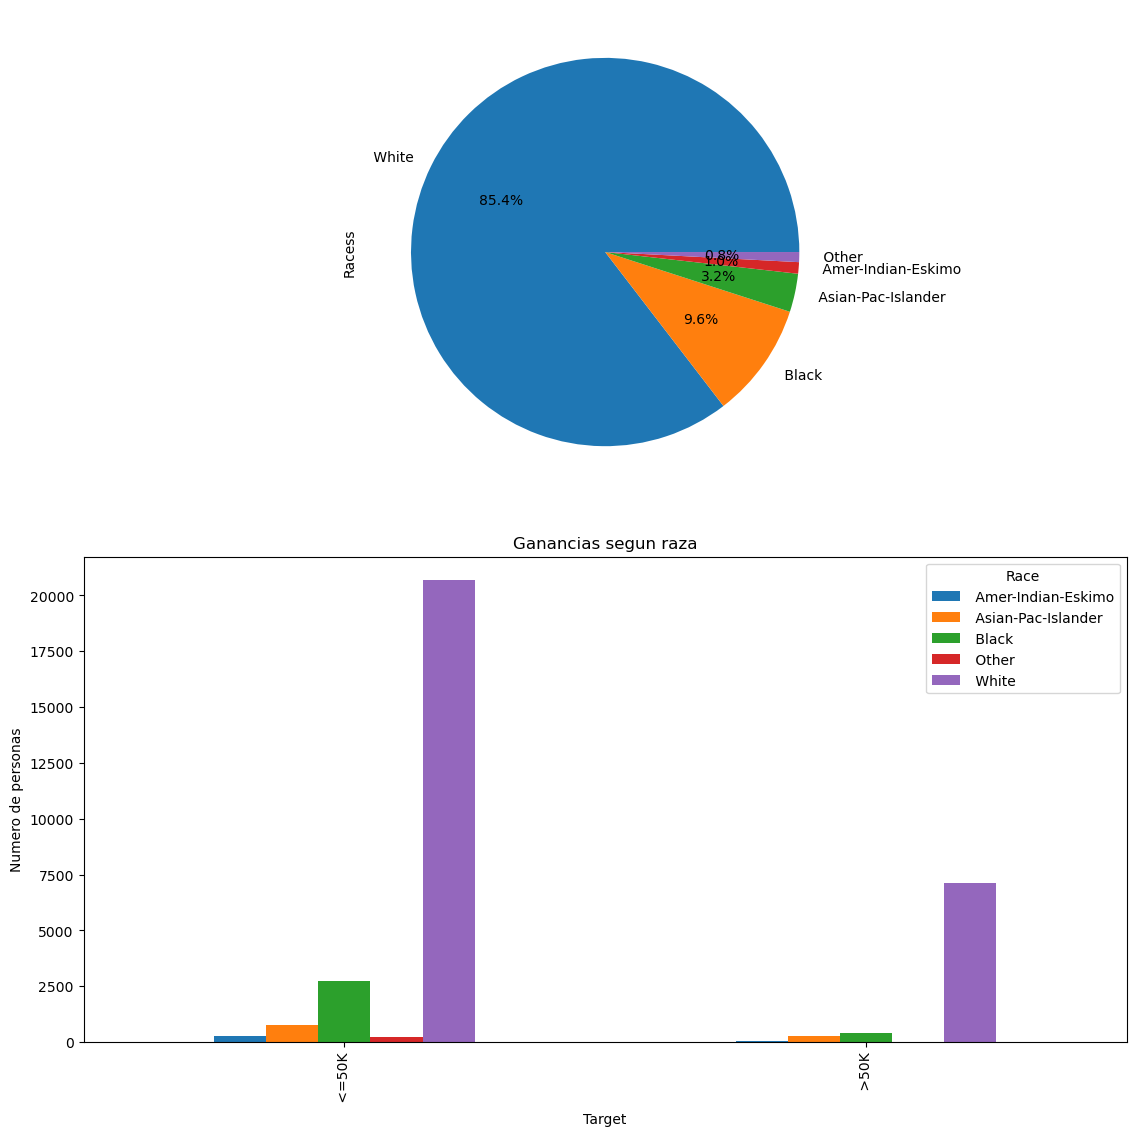

In [87]:
fig, ax = plt.subplots(2,figsize=(12,12))
df.Race.value_counts().plot(kind='pie',ax=ax[0],autopct='%1.1f%%',label='Racess')
df.groupby('Target')['Race'].value_counts().unstack().plot(kind='bar',
                                                                title='Ganancias segun raza',
                                                               ylabel='Numero de personas',
                                                              ax=ax[1])
plt.tight_layout(pad=3)

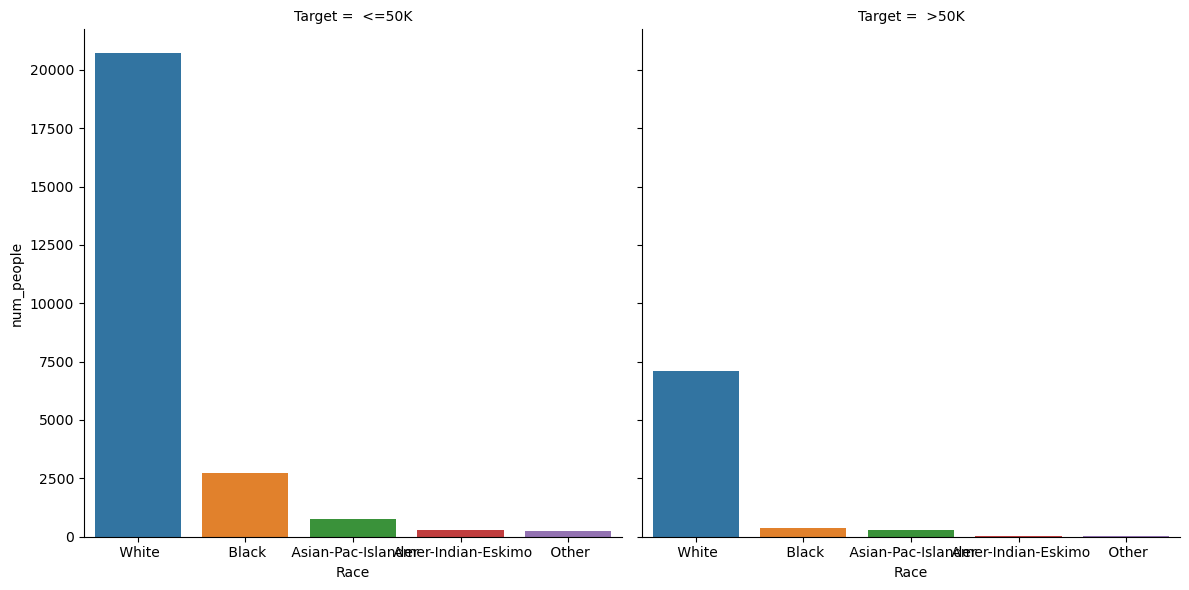

In [105]:
sns.catplot(data=df.groupby('Target')['Race'].value_counts().reset_index(name='num_people'), x='Race',y='num_people',col='Target',kind='bar',height=6)

<Axes: title={'center': 'Ganancias segun sexo'}, xlabel='Target', ylabel='Numero de personas'>

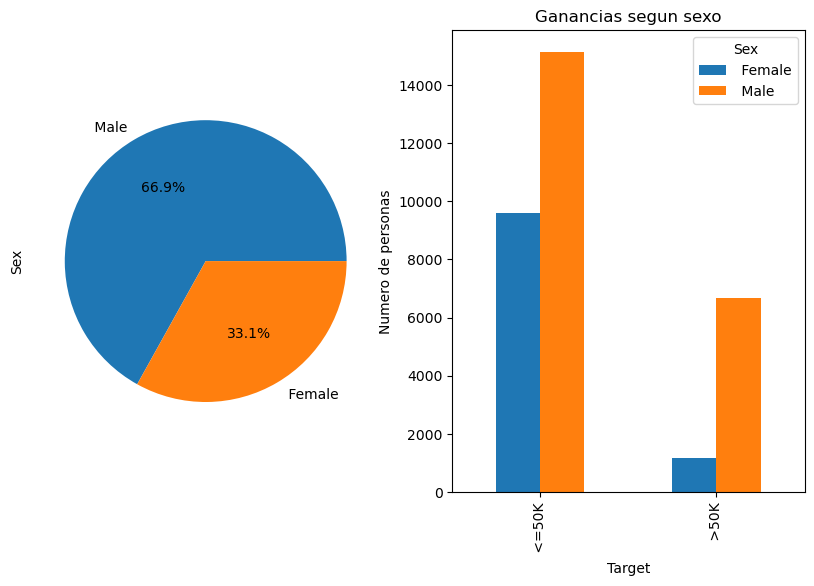

In [109]:
figs, axi = plt.subplots(1,2,figsize=(10,6))
df.Sex.value_counts().plot(kind='pie',autopct='%1.1f%%',ax=axi[0])
df.groupby('Target')['Sex'].value_counts().unstack().plot(kind='bar',
                                                                title='Ganancias segun sexo',
                                                               ylabel='Numero de personas',
                                                              ax=axi[1])

# ML

## Featuring Engineer

In [7]:
dfc = df.copy()

In [8]:
dfc.drop('EducationClassification',axis=1,inplace=True)

In [9]:
dfc.Target.replace({' <=50K':0,' >50K':1},inplace=True)
cat_cols = dfc.select_dtypes(include='object').columns
dfc = pd.concat([dfc.drop(cat_cols.tolist(),axis=1),pd.get_dummies(dfc[cat_cols])],axis=1)

In [234]:
X

,Age,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,2174,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,0,0,13,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,38,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,0,38,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,0,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,0,0,20,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
X = dfc.drop('Target',axis=1)
y = dfc.Target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=0)

In [11]:
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [36]:
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score

### XGBClassifier

In [15]:
space = {'max_depth': hp.quniform('max_depth',1,20,1),'n_estimators':hp.quniform('n_estimators',50,150,1),'learning_rate':hp.uniform('learning_rate',0.001,1),'subsample':hp.uniform('subsample',0,1),'reg_alpha':hp.quniform('reg_alpha',0,50,1),'reg_lambda':hp.quniform('reg_lambda',0,50,1)}
def objective(space):
    model = XGBClassifier(max_depth=int(space['max_depth']),n_estimators=int(space['n_estimators']),learning_rate=space['learning_rate'],subsample=space['subsample'],reg_alpha=int(space['reg_alpha']),reg_lambda=int(space['reg_lambda']))
    evaluation = [( X_train, y_train), (X_test,y_test)]
    model.fit(X_train, y_train,eval_set=evaluation)
    pred = model.predict(X_test)
    f1 = metrics.f1_score(y_test, pred>0.5)
    return {'loss': -f1, 'status': STATUS_OK }
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

[0]	validation_0-logloss:0.42424	validation_1-logloss:0.42823
[1]	validation_0-logloss:0.37300	validation_1-logloss:0.37737
[2]	validation_0-logloss:0.34345	validation_1-logloss:0.34869
[3]	validation_0-logloss:0.32630	validation_1-logloss:0.33239
[4]	validation_0-logloss:0.31567	validation_1-logloss:0.32295
[5]	validation_0-logloss:0.30870	validation_1-logloss:0.31771
[6]	validation_0-logloss:0.30308	validation_1-logloss:0.31334
[7]	validation_0-logloss:0.29908	validation_1-logloss:0.31046
[8]	validation_0-logloss:0.29581	validation_1-logloss:0.30807
[9]	validation_0-logloss:0.29421	validation_1-logloss:0.30737
[10]	validation_0-logloss:0.29150	validation_1-logloss:0.30554
[11]	validation_0-logloss:0.29039	validation_1-logloss:0.30498
[12]	validation_0-logloss:0.28869	validation_1-logloss:0.30381
[13]	validation_0-logloss:0.28723	validation_1-logloss:0.30315
[14]	validation_0-logloss:0.28607	validation_1-logloss:0.30230
[15]	validation_0-logloss:0.28467	validation_1-logloss:0.30152
[1

[1]	validation_0-logloss:0.40523	validation_1-logloss:0.40667                    
[2]	validation_0-logloss:0.37501	validation_1-logloss:0.37765                    
[3]	validation_0-logloss:0.35636	validation_1-logloss:0.35978                    
[4]	validation_0-logloss:0.34479	validation_1-logloss:0.34910                    
[5]	validation_0-logloss:0.33410	validation_1-logloss:0.33979                    
[6]	validation_0-logloss:0.32671	validation_1-logloss:0.33262                    
[7]	validation_0-logloss:0.32174	validation_1-logloss:0.32833                    
[8]	validation_0-logloss:0.31761	validation_1-logloss:0.32431                    
[9]	validation_0-logloss:0.31408	validation_1-logloss:0.32078                    
[10]	validation_0-logloss:0.31144	validation_1-logloss:0.31831                   
[11]	validation_0-logloss:0.30998	validation_1-logloss:0.31725                   
[12]	validation_0-logloss:0.30772	validation_1-logloss:0.31543                   
[13]	validation_

[100]	validation_0-logloss:0.27782	validation_1-logloss:0.29636                  
[101]	validation_0-logloss:0.27775	validation_1-logloss:0.29645                  
[102]	validation_0-logloss:0.27763	validation_1-logloss:0.29658                  
[103]	validation_0-logloss:0.27746	validation_1-logloss:0.29676                  
[104]	validation_0-logloss:0.27731	validation_1-logloss:0.29666                  
[105]	validation_0-logloss:0.27709	validation_1-logloss:0.29646                  
[0]	validation_0-logloss:0.38743	validation_1-logloss:0.39388                    
[1]	validation_0-logloss:0.34282	validation_1-logloss:0.35191                    
[2]	validation_0-logloss:0.31882	validation_1-logloss:0.33021                    
[3]	validation_0-logloss:0.30611	validation_1-logloss:0.32031                    
[4]	validation_0-logloss:0.29893	validation_1-logloss:0.31518                    
[5]	validation_0-logloss:0.29432	validation_1-logloss:0.31193                    
[6]	validation_0

[25]	validation_0-logloss:0.30008	validation_1-logloss:0.30979                   
[26]	validation_0-logloss:0.29976	validation_1-logloss:0.30957                   
[27]	validation_0-logloss:0.29940	validation_1-logloss:0.30945                   
[28]	validation_0-logloss:0.29900	validation_1-logloss:0.30908                   
[29]	validation_0-logloss:0.29870	validation_1-logloss:0.30891                   
[30]	validation_0-logloss:0.29840	validation_1-logloss:0.30867                   
[31]	validation_0-logloss:0.29810	validation_1-logloss:0.30834                   
[32]	validation_0-logloss:0.29776	validation_1-logloss:0.30798                   
[33]	validation_0-logloss:0.29745	validation_1-logloss:0.30774                   
[34]	validation_0-logloss:0.29724	validation_1-logloss:0.30743                   
[35]	validation_0-logloss:0.29689	validation_1-logloss:0.30717                   
[36]	validation_0-logloss:0.29689	validation_1-logloss:0.30717                   
[37]	validation_

[37]	validation_0-logloss:0.32660	validation_1-logloss:0.33245                   
[38]	validation_0-logloss:0.32660	validation_1-logloss:0.33245                   
[39]	validation_0-logloss:0.32662	validation_1-logloss:0.33261                   
[40]	validation_0-logloss:0.32662	validation_1-logloss:0.33261                   
[41]	validation_0-logloss:0.32618	validation_1-logloss:0.33239                   
[42]	validation_0-logloss:0.32513	validation_1-logloss:0.33146                   
[43]	validation_0-logloss:0.32462	validation_1-logloss:0.33083                   
[44]	validation_0-logloss:0.32391	validation_1-logloss:0.33012                   
[45]	validation_0-logloss:0.32391	validation_1-logloss:0.33012                   
[46]	validation_0-logloss:0.32391	validation_1-logloss:0.33012                   
[47]	validation_0-logloss:0.32391	validation_1-logloss:0.33012                   
[48]	validation_0-logloss:0.32391	validation_1-logloss:0.33012                   
[49]	validation_

[61]	validation_0-logloss:0.26702	validation_1-logloss:0.29366                   
[62]	validation_0-logloss:0.26675	validation_1-logloss:0.29352                   
[63]	validation_0-logloss:0.26665	validation_1-logloss:0.29365                   
[64]	validation_0-logloss:0.26646	validation_1-logloss:0.29359                   
[65]	validation_0-logloss:0.26613	validation_1-logloss:0.29359                   
[66]	validation_0-logloss:0.26606	validation_1-logloss:0.29368                   
[67]	validation_0-logloss:0.26582	validation_1-logloss:0.29349                   
[68]	validation_0-logloss:0.26568	validation_1-logloss:0.29345                   
[69]	validation_0-logloss:0.26540	validation_1-logloss:0.29367                   
[70]	validation_0-logloss:0.26527	validation_1-logloss:0.29353                   
[71]	validation_0-logloss:0.26483	validation_1-logloss:0.29363                   
[72]	validation_0-logloss:0.26477	validation_1-logloss:0.29384                   
[73]	validation_

[47]	validation_0-logloss:0.27096	validation_1-logloss:0.29582                  
[48]	validation_0-logloss:0.27072	validation_1-logloss:0.29573                  
[49]	validation_0-logloss:0.27061	validation_1-logloss:0.29579                  
[50]	validation_0-logloss:0.27054	validation_1-logloss:0.29571                  
[51]	validation_0-logloss:0.27054	validation_1-logloss:0.29571                  
[52]	validation_0-logloss:0.27045	validation_1-logloss:0.29578                  
[53]	validation_0-logloss:0.27045	validation_1-logloss:0.29578                  
[54]	validation_0-logloss:0.27034	validation_1-logloss:0.29574                  
[55]	validation_0-logloss:0.27034	validation_1-logloss:0.29574                  
[56]	validation_0-logloss:0.27022	validation_1-logloss:0.29561                  
[57]	validation_0-logloss:0.27013	validation_1-logloss:0.29564                  
[58]	validation_0-logloss:0.27013	validation_1-logloss:0.29564                  
[59]	validation_0-logloss:0.

[68]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[69]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[70]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[71]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[72]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[73]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[74]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[75]	validation_0-logloss:0.31057	validation_1-logloss:0.31703                   
[76]	validation_0-logloss:0.31035	validation_1-logloss:0.31686                   
[77]	validation_0-logloss:0.31035	validation_1-logloss:0.31686                   
[78]	validation_0-logloss:0.31035	validation_1-logloss:0.31686                   
[79]	validation_0-logloss:0.31035	validation_1-logloss:0.31686                   
[80]	validation_

[50]	validation_0-logloss:0.28334	validation_1-logloss:0.29958                   
[51]	validation_0-logloss:0.28318	validation_1-logloss:0.29946                   
[52]	validation_0-logloss:0.28300	validation_1-logloss:0.29933                   
[53]	validation_0-logloss:0.28293	validation_1-logloss:0.29934                   
[54]	validation_0-logloss:0.28277	validation_1-logloss:0.29937                   
[55]	validation_0-logloss:0.28263	validation_1-logloss:0.29927                   
[56]	validation_0-logloss:0.28254	validation_1-logloss:0.29912                   
[57]	validation_0-logloss:0.28224	validation_1-logloss:0.29886                   
[58]	validation_0-logloss:0.28205	validation_1-logloss:0.29873                   
[59]	validation_0-logloss:0.28195	validation_1-logloss:0.29863                   
[60]	validation_0-logloss:0.28183	validation_1-logloss:0.29850                   
[61]	validation_0-logloss:0.28167	validation_1-logloss:0.29848                   
[62]	validation_

In [16]:
best_hyperparams

{'learning_rate': 0.5452770211885286,
 'max_depth': 17.0,
 'n_estimators': 79.0,
 'reg_alpha': 23.0,
 'reg_lambda': 20.0,
 'subsample': 0.9594885564048067}

In [17]:
error_eval_metric_best_params = {'learning_rate': 0.5452770211885286,
 'max_depth': 17,
 'n_estimators': 79.0,
 'reg_alpha': 23.0,
 'reg_lambda': 20.0,
 'subsample': 0.9594885564048067}

# Test

In [21]:
test = pd.read_csv(r'C:\Programacion\Datasets\archive (1)\adult_test.csv')

In [22]:
test.dropna(inplace=True)

In [23]:
testc = test.copy()

In [24]:
testc.drop(['fnlwgt','Education_Num'],axis=1,inplace=True)

In [25]:
testc.Age = testc.Age.astype(int)
testc.Target.replace({' <=50K.':0,' >50K.':1},inplace=True)

In [26]:
cat_cols = testc.select_dtypes(include='object').columns
testc = pd.concat([testc.drop(cat_cols.tolist(),axis=1),pd.get_dummies(testc[cat_cols])],axis=1)
testc = testc.reset_index(drop=True)

In [27]:
holand = pd.Series(np.zeros_like(testc.Target),name='Country_ Holand-Netherlands')
workclass = pd.Series(np.zeros_like(testc.Target),name='Workclass_ Never-worked')

In [28]:
testc = pd.concat([testc.loc[:,:'Workclass_ Local-gov'],workclass,testc.loc[:,'Workclass_ Private':'Country_ Haiti'],holand,testc.loc[:,'Country_ Honduras':]],axis=1)

# Final model

In [ ]:
xgb = XGBClassifier(max_depth=2,n_estimators=100,learning_rate=0.9124915565244662,subsample=0.8333000121724218)

In [317]:
xgb.fit(X,y)
y_pred = xgb.predict(testc.drop('Target',axis=1))

In [30]:
y_pred = xgb.predict(testc.drop('Target',axis=1))

In [33]:
print(f'{accuracy_score(testc.Target,y_pred)},{precision_score(testc.Target,y_pred)},{recall_score(testc.Target,y_pred)},{f1_score(testc.Target,y_pred)}')

0.8575033200531208,0.746510152284264,0.635945945945946,0.6868067717454758
